In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from skimage import filters
from skimage.measure import shannon_entropy

# 설정
base_dir = "../datasets/images-classification"
classes = ['car', 'chair', 'dog', 'person', 'plate']  # 또는 'all' 사용 가능

# 함수: 통계 수집
def collect_image_stats(base_dir, classes):
    data = []
    if classes == 'all':
        classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        for fname in tqdm(os.listdir(cls_path), desc=f"Reading {cls}"):
            fpath = os.path.join(cls_path, fname)
            try:
                with Image.open(fpath) as img:
                    img = img.convert('RGB')
                    arr = np.array(img)
                    r_mean = arr[:, :, 0].mean()
                    g_mean = arr[:, :, 1].mean()
                    b_mean = arr[:, :, 2].mean()
                    gray = np.array(img.convert('L'))
                    entropy = shannon_entropy(gray)
                    blur = filters.laplace(gray).var()
                    data.append({
                        "class": cls,
                        "filename": fname,
                        "r_mean": r_mean,
                        "g_mean": g_mean,
                        "b_mean": b_mean,
                        "entropy": entropy,
                        "blur": blur,
                    })
            except Exception as e:
                print(f"Skipped {fname}: {e}")
    return pd.DataFrame(data)

df = collect_image_stats(base_dir, classes)

Reading car:  70%|███████   | 49/70 [00:07<00:01, 10.95it/s]/opt/homebrew/Caskroom/miniforge/base/envs/model-playground-mac/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Reading plate: 100%|██████████| 85/85 [00:10<00:00,  8.25it/s]


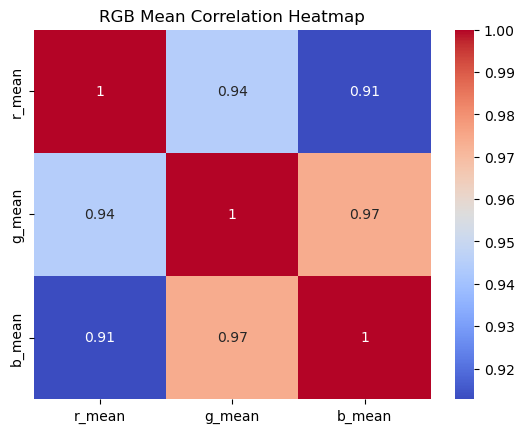

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['r_mean', 'g_mean', 'b_mean']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("RGB Mean Correlation Heatmap")
plt.show()

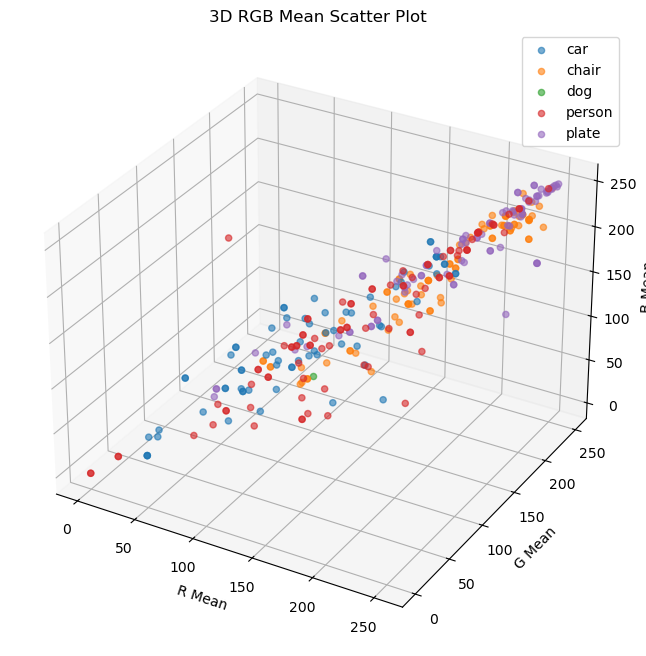

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cls in df['class'].unique():
    cls_df = df[df['class'] == cls]
    ax.scatter(cls_df['r_mean'], cls_df['g_mean'], cls_df['b_mean'], label=cls, alpha=0.6)

ax.set_xlabel('R Mean')
ax.set_ylabel('G Mean')
ax.set_zlabel('B Mean')
ax.set_title('3D RGB Mean Scatter Plot')
ax.legend()
plt.show()
import plotly.express as px

fig = px.scatter_3d(
    df,
    x='r_mean',
    y='g_mean',
    z='b_mean',
    color='class',
    hover_name='filename',  # 여기에 파일명을 지정하면 마우스 올렸을 때 보입니다
    title="3D RGB Mean Scatter (Interactive)",
    opacity=0.7
)

fig.show()

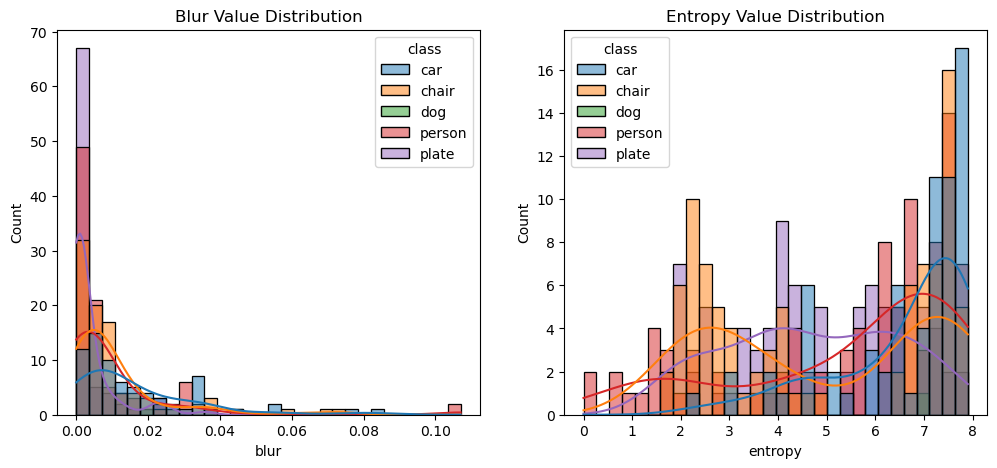

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='blur', hue='class', bins=30, kde=True)
plt.title("Blur Value Distribution")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='entropy', hue='class', bins=30, kde=True)
plt.title("Entropy Value Distribution")
plt.show()

In [22]:
def filter_images_by_range(df, column, value_range):
    """
    지정한 컬럼에서 특정 값 범위에 해당하는 이미지 파일명 리스트를 반환합니다.

    Parameters:
    - df (pd.DataFrame): 분석용 데이터프레임 (filename 포함)
    - column (str): 'blur' 또는 'entropy'
    - value_range (tuple): (min_val, max_val) 형태의 범위

    Returns:
    - list of filenames
    """
    min_val, max_val = value_range
    filtered_df = df[(df[column] >= min_val) & (df[column] <= max_val)]
    
    return (filtered_df['class'] + '/' + filtered_df['filename']).tolist()

In [23]:
# 블러가 10 ~ 30 사이인 이미지
blur_range=(0.08, 30)
blur_images = filter_images_by_range(df, column='blur', value_range=blur_range)
print(f"Blur {blur_range} 범위 이미지:", blur_images)

# 엔트로피가 3 ~ 5 사이인 이미지
entropy_range=(0, 3)
entropy_images = filter_images_by_range(df, column='entropy', value_range=entropy_range)
print(f"Entropy {entropy_range} 범위 이미지:", entropy_images)

Blur (0.08, 30) 범위 이미지: ['car/000037.jpg', 'person/000055.jpg', 'person/000073.jpg']
Entropy (0, 3) 범위 이미지: ['car/000028.png', 'chair/000027.png', 'chair/000019.jpg', 'chair/000030.jpg', 'chair/000035.jpg', 'chair/000023.jpg', 'chair/000037.jpg', 'chair/000036.jpg', 'chair/000022.jpg', 'chair/000051.jpg', 'chair/000044.jpg', 'chair/000052.jpg', 'chair/000047.jpg', 'chair/000043.jpg', 'chair/000068.jpg', 'chair/000055.png', 'chair/000064.jpg', 'chair/000070.jpg', 'chair/000073.jpg', 'chair/000063.jpg', 'chair/000060.png', 'chair/000007.png', 'chair/000006.png', 'chair/000038.png', 'chair/000004.jpg', 'chair/000005.jpg', 'chair/000039.jpg', 'chair/000005.png', 'chair/000015.png', 'chair/000015.jpg', 'chair/000001.jpg', 'chair/000016.png', 'chair/000017.jpg', 'chair/000017.png', 'person/000032.png', 'person/000033.png', 'person/000031.jpg', 'person/000018.png', 'person/000021.png', 'person/000037.png', 'person/000050.jpg', 'person/000052.jpg', 'person/000053.jpg', 'person/000068.jpg', 'pe

In [16]:
df

,class,filename,r_mean,g_mean,b_mean,entropy,blur
0,car,000026.jpg,176.453331,123.431629,66.861158,7.316354,0.001864
1,car,000032.jpg,113.612074,108.002999,96.843923,7.603349,0.012788
2,car,000033.jpg,200.257515,170.172990,194.889524,4.551552,0.002846
3,car,000027.jpg,140.177539,139.328560,139.125739,7.316121,0.007293
4,car,000030.jpeg,97.809610,79.544627,53.232907,7.504757,0.005618
...,...,...,...,...,...,...,...
335,plate,000002.jpg,169.602042,166.157032,160.528860,6.317829,0.000090
336,plate,000016.jpg,176.333798,167.237496,171.422562,6.971590,0.006451
337,plate,000017.jpg,250.507694,250.416196,250.002388,2.547360,0.000007
338,plate,000003.jpg,109.389841,110.095902,105.782503,7.722976,0.021401
